In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [8]:
calendar = pd.read_csv("calendar.csv")
sales = pd.read_csv("sales_train_validation.csv")
sell_price = pd.read_csv("sell_prices.csv")

In [9]:
for_use = sales.iloc[:,:-28]
valid = pd.concat([sales.iloc[:,:6], sales.iloc[:,-28:]], axis = 1)

In [10]:
# Group by category & state
for_use[(for_use['cat_id']=='HOBBIES')&(for_use['state_id']=='CA')].shape
sales_g1 = for_use[(for_use['cat_id']=='HOBBIES')&(for_use['state_id']=='CA')]

In [11]:
# Transform the data
sales_g1_melt = pd.melt(sales_g1, id_vars=sales_g1.columns[:6], value_vars=sales_g1.columns[6:])
sales_g1_melt.columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales']

In [12]:
# Merge all dataset
sales_g1_melt_merge = pd.merge(sales_g1_melt, calendar)
sales_g1_melt_merge = pd.merge(sales_g1_melt_merge, sell_price, how = 'left')
sales_g1_melt_merge = sales_g1_melt_merge.sort_values(['id', 'date']).reset_index(drop = True)

In [13]:
# Drop some useless columns
df = sales_g1_melt_merge[['item_id', 'dept_id', 'store_id', 'd', 'sales', 'wm_yr_wk', 'wday', 'month', 'year',
                          'event_name_1', 'event_name_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price']].copy()

In [14]:
df

,item_id,dept_id,store_id,d,sales,wm_yr_wk,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001,HOBBIES_1,CA_1,d_338,0,11149,2,1,2012,NewYear,NaN,1,1,0,NaN
1,HOBBIES_1_001,HOBBIES_1,CA_1,d_704,0,11249,4,1,2013,NewYear,NaN,1,1,0,NaN
2,HOBBIES_1_001,HOBBIES_1,CA_1,d_1069,1,11349,5,1,2014,NewYear,NaN,1,1,0,8.26
3,HOBBIES_1_001,HOBBIES_1,CA_1,d_1434,0,11448,6,1,2015,NewYear,NaN,1,1,0,8.26
4,HOBBIES_1_001,HOBBIES_1,CA_1,d_1799,0,11548,7,1,2016,NewYear,NaN,1,1,0,8.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4260095,HOBBIES_2_149,HOBBIES_2,CA_4,d_224,0,11132,7,9,2011,NaN,NaN,1,1,1,NaN
4260096,HOBBIES_2_149,HOBBIES_2,CA_4,d_590,0,11233,2,9,2012,NaN,NaN,1,1,1,NaN
4260097,HOBBIES_2_149,HOBBIES_2,CA_4,d_955,0,11333,3,9,2013,NaN,NaN,1,1,1,2.47
4260098,HOBBIES_2_149,HOBBIES_2,CA_4,d_1320,0,11432,4,9,2014,NaN,NaN,1,1,1,0.97


In [15]:
# df['event_name_1'] = (df['event_name_1'].notnull()).astype('int')
# df['event_name_2'] = (df['event_name_2'].notnull()).astype('int')
df['wm_yr_wk'] = df['wm_yr_wk'].apply(lambda x: int(str(x)[-2:]))

### Encoding Events

In [16]:
df['event_name_1_Name'] = df['event_name_1']
df['event_name_2_Name'] = df['event_name_2']

In [17]:
# Missing value: NaN = 0
# astype('str') since LabelEncoder needs consistent datatype
df["event_name_1"] = df["event_name_1"].fillna(0).astype('str')
df["event_name_2"] = df["event_name_2"].fillna(0).astype('str')

In [18]:
# Encode the events
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df["event_name_1"] = labelencoder.fit_transform(df["event_name_1"])
df["event_name_2"] = labelencoder.fit_transform(df["event_name_2"])

### Accumulated (2011-2016 in total) Sales based on Event 1-30

In [19]:
df_with_event1 = df.loc[df['event_name_1'] != 0]
df_without_event1 = df.loc[df['event_name_1'] == 0]

    event_name_1    event_name_1_Name  sales
0              1         Chanukah End   7858
1              2            Christmas      0
2              3        Cinco De Mayo   6008
3              4          ColumbusDay   7438
4              5               Easter   7659
5              6          Eid al-Fitr   7467
6              7            EidAlAdha   7681
7              8         Father's day   6861
8              9            Halloween   7749
9             10      IndependenceDay   6482
10            11             LaborDay   7348
11            12            LentStart   8852
12            13            LentWeek2   9093
13            14  MartinLutherKingDay   7977
14            15          MemorialDay   7598
15            16         Mother's day   7564
16            17         NBAFinalsEnd   7560
17            18       NBAFinalsStart   7418
18            19              NewYear   5703
19            20    OrthodoxChristmas   7414
20            21       OrthodoxEaster   6860
21        

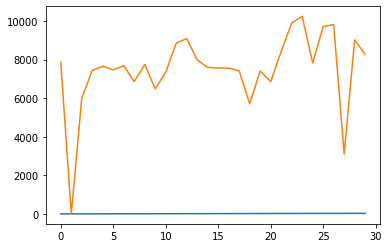

In [20]:
with_event1_Name = pd.DataFrame(df_with_event1['sales'].groupby(df_with_event1['event_name_1_Name']).sum()).reset_index()
with_event1_number = pd.DataFrame(df_with_event1['sales'].groupby(df_with_event1['event_name_1']).sum()).reset_index()
event_1 = pd.merge(with_event1_number, with_event1_Name)
event_1 = event_1[['event_name_1', 'event_name_1_Name', 'sales']]
# without_event1 = df_without_event1['sales'].groupby(df_without_event1['year']).sum()
print(event_1)
plt.plot(with_event1_number)

### Sales of Event 1-30 based in different year

In [ ]:
each_event_yearly = df_with_event1.groupby(['event_name_1', 'year']).sum()
for i in range(1, 31):
    x = each_event_yearly['sales'].loc[i]
    plt.plot(x)

In [ ]:
# unused

each_event_yearly_2 = df_with_event1.groupby(['event_name_1', 'year']).sum().reset_index()
each_event_yearly_2

x = each_event_yearly_2.groupby('event_name_1')
print(x)

### Weigh the "Event" Feature base on Total Sales Volume in 2011-2016
* The higher the event boosts sales, the more the event weighted.

In [21]:
event_1 = event_1.sort_values(by = ['sales'])
event_1['event_weighted'] = range(1, len(event_1)+1)
# event_1
event_1_dict = event_1.set_index('event_name_1_Name').T.to_dict('int')
event_1_dict['event_weighted']

{'Christmas': 1,
 'Thanksgiving': 2,
 'NewYear': 3,
 'Cinco De Mayo': 4,
 'IndependenceDay': 5,
 'OrthodoxEaster': 6,
 "Father's day": 7,
 'LaborDay': 8,
 'OrthodoxChristmas': 9,
 'NBAFinalsStart': 10,
 'ColumbusDay': 11,
 'Eid al-Fitr': 12,
 'NBAFinalsEnd': 13,
 "Mother's day": 14,
 'MemorialDay': 15,
 'Easter': 16,
 'EidAlAdha': 17,
 'Halloween': 18,
 'Ramadan starts': 19,
 'Chanukah End': 20,
 'MartinLutherKingDay': 21,
 'VeteransDay': 22,
 'Pesach End': 23,
 'LentStart': 24,
 'ValentinesDay': 25,
 'LentWeek2': 26,
 'StPatricksDay': 27,
 'SuperBowl': 28,
 'PresidentsDay': 29,
 'Purim End': 30}

* Reference for updating column with dictionary values: https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict 

In [22]:
df = df.set_index('event_name_1_Name')

In [23]:
df['event_name_1'].update(pd.Series(event_1_dict['event_weighted']))

In [24]:
df = df.reset_index()
df['event_name_1'] = df['event_name_1'].astype('int')
df['event_name_2'] = df['event_name_2'].astype('int')

In [25]:
# train : d_1 ~ d_1913
train = df.loc[df['d'].isin(list(df['d'].unique()[:-56]))]
# train : d_1914 ~ d_1969
test = df.loc[df['d'].isin(list(df['d'].unique()[-56:]))]

In [ ]:
train

In [ ]:
# Drop the data with no price info
train = train[train['sell_price'].notna()]

In [ ]:
train

In [ ]:
print(type(train['sales']))

In [ ]:
X_train = train[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']]
y_train = train['sales'].fillna(0).astype('int')
X_test = test[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']]
y_test = test['sales']

## Start to Run from Here... :-)

In [ ]:
# !pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [2]:
calendar = pd.read_csv("calendar.csv")
sales = pd.read_csv("sales_train_validation.csv")
sell_price = pd.read_csv("sell_prices.csv")

### Fill in the columns to be predicted 

In [3]:
sales_fill_date = sales.copy()
date_list = []
for i in range(1914, 1970):
    date_list.append('d_'+str(i))
fill_date = pd.DataFrame(columns = date_list)
sales_fill_date = pd.concat([sales_fill_date, fill_date], axis = 1)
# print(sales_fill_date)

In [4]:
final_all = pd.DataFrame()
for cat in sales['cat_id'].unique():
    for state in sales['state_id'].unique():
        sales_group = sales_fill_date[(sales_fill_date['cat_id']==cat)&(sales_fill_date['state_id']==state)]
        sales_group_melt = pd.melt(sales_group, id_vars=sales_group.columns[:6], value_vars=sales_group.columns[6:])
        sales_group_melt.columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales']
        sales_group_melt_merge = pd.merge(sales_group_melt, calendar)
        sales_group_melt_merge = pd.merge(sales_group_melt_merge, sell_price, how = 'left')
        sales_group_melt_merge = sales_group_melt_merge.sort_values(['id', 'date']).reset_index(drop = True)
        if state == 'CA':
            df = sales_group_melt_merge[['id', 'item_id', 'dept_id', 'store_id', 'd', 'sales', 'wm_yr_wk', 'wday', 'month', 'year',
                                      'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']].copy()
        elif state == 'TX':
            df = sales_group_melt_merge[['id', 'item_id', 'dept_id', 'store_id', 'd', 'sales', 'wm_yr_wk', 'wday', 'month', 'year',
                                      'event_name_1', 'event_name_2', 'snap_TX', 'sell_price']].copy()
        else:
            df = sales_group_melt_merge[['id', 'item_id', 'dept_id', 'store_id', 'd', 'sales', 'wm_yr_wk', 'wday', 'month', 'year',
                                         'event_name_1', 'event_name_2', 'snap_WI', 'sell_price']].copy()
        # df['event_name_1'] = (df['event_name_1'].notnull()).astype('int')
        # df['event_name_2'] = (df['event_name_2'].notnull()).astype('int')
        # Extract the last two digits for week info
        df['wm_yr_wk'] = df['wm_yr_wk'].apply(lambda x: int(str(x)[-2:]))
        
        
        ### Encoding Events & Add Weight
        df['event_name_1_Name'] = df['event_name_1']
        df['event_name_2_Name'] = df['event_name_2']
        
        df["event_name_1"] = df["event_name_1"].fillna(0).astype('str')
        df["event_name_2"] = df["event_name_2"].fillna(0).astype('str')
        
        labelencoder = LabelEncoder()
        df["event_name_1"] = labelencoder.fit_transform(df["event_name_1"])
        df["event_name_2"] = labelencoder.fit_transform(df["event_name_2"])
        
        df_with_event1 = df.loc[df['event_name_1'] != 0]
        df_without_event1 = df.loc[df['event_name_1'] == 0]
        
        with_event1_Name = pd.DataFrame(df_with_event1['sales'].groupby(df_with_event1['event_name_1_Name']).sum()).reset_index()
        with_event1_number = pd.DataFrame(df_with_event1['sales'].groupby(df_with_event1['event_name_1']).sum()).reset_index()
        event_1 = pd.merge(with_event1_number, with_event1_Name)
        event_1 = event_1[['event_name_1', 'event_name_1_Name', 'sales']]
        
        event_1 = event_1.sort_values(by = ['sales'])
        event_1['event_weighted'] = range(1, len(event_1)+1)
        event_1_dict = event_1.set_index('event_name_1_Name').T.to_dict('int')
        
        df = df.set_index('event_name_1_Name')
        df['event_name_1'].update(pd.Series(event_1_dict['event_weighted']))
        df = df.reset_index()
        df['event_name_1'] = df['event_name_1'].astype('int')
        df['event_name_2'] = df['event_name_2'].astype('int')
        ###
        
        train = df.loc[df['d'].isin(list(df['d'].unique()[:-56]))]
        test = df.loc[df['d'].isin(list(df['d'].unique()[-56:]))]
        
        train = train[train['sell_price'].notna()]
        if state == 'CA':
            X_train = train[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']]
            X_test = test[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']]
        elif state == 'TX':
            X_train = train[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_TX', 'sell_price']]
            X_test = test[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_TX', 'sell_price']]
        else:
            X_train = train[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_WI', 'sell_price']]
            X_test = test[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_WI', 'sell_price']]
        y_train = train['sales'].fillna(0).astype('int')    # Add fillna(0)
        y_test = test['sales']

        # Modeling
        lgbm = lgb.LGBMRegressor()
        lgbm.fit(X_train, y_train)
        lgbm_pred = lgbm.predict(X_test)
        lgbm_pred = np.round(lgbm_pred, 0)
        final_pred = pd.concat([test[['id', 'd']].reset_index(drop=True), pd.DataFrame(lgbm_pred)], axis=1)
        final_pred.columns = ['id', 'd', 'values']
        final_pred = final_pred.pivot(index='id', columns='d', values='values').reset_index()
        
        final_all = pd.concat([final_all, final_pred], axis = 0)
        
print(final_all)

d                                id  d_1314  d_1315  d_1316  d_1317  d_1318  \
0     HOBBIES_1_001_CA_1_validation     1.0     1.0     1.0     1.0     1.0   
1     HOBBIES_1_001_CA_2_validation     1.0     1.0     1.0     1.0     1.0   
2     HOBBIES_1_001_CA_3_validation     1.0     1.0     1.0     1.0     1.0   
3     HOBBIES_1_001_CA_4_validation     1.0     1.0     1.0     1.0     1.0   
4     HOBBIES_1_002_CA_1_validation     0.0     0.0     0.0     0.0     0.0   
...                             ...     ...     ...     ...     ...     ...   
4306    FOODS_3_826_WI_2_validation     2.0     2.0     2.0     3.0     2.0   
4307    FOODS_3_826_WI_3_validation     2.0     2.0     2.0     3.0     2.0   
4308    FOODS_3_827_WI_1_validation     4.0     3.0     4.0     5.0     4.0   
4309    FOODS_3_827_WI_2_validation    17.0     9.0    17.0    21.0    12.0   
4310    FOODS_3_827_WI_3_validation     4.0     3.0     4.0     5.0     4.0   

d     d_1319  d_1320  d_1338  d_1339  ...  d_950  d

### Final submission processing

In [6]:
# Validation : d_1914 ~ d_1941
final_val = final_all.iloc[:,:29]
# Evaluation : d_1942 ~ d_1969
final_eval = pd.concat([final_all.iloc[:,0], final_all.iloc[:,29:]], axis = 1)
final_eval['id'] = final_eval['id'].str.replace('validation', 'evaluation')

submission_colnames = ['id']
for i in range(1,29):
    submission_colnames.append('F'+str(i))

final_val.columns = submission_colnames
final_eval.columns = submission_colnames

submission = pd.concat([final_val, final_eval], axis = 0)
# submission.to_csv(r'C:\Users\Katy\Desktop\Kaggle\submission.csv', index = False)
print(submission)

                                 id    F1    F2    F3    F4    F5    F6    F7  \
0     HOBBIES_1_001_CA_1_validation   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1     HOBBIES_1_001_CA_2_validation   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2     HOBBIES_1_001_CA_3_validation   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3     HOBBIES_1_001_CA_4_validation   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
4     HOBBIES_1_002_CA_1_validation   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                             ...   ...   ...   ...   ...   ...   ...   ...   
4306    FOODS_3_826_WI_2_evaluation  19.0  19.0  10.0  10.0  11.0  11.0  20.0   
4307    FOODS_3_826_WI_3_evaluation  19.0  19.0  10.0  10.0  11.0  11.0  20.0   
4308    FOODS_3_827_WI_1_evaluation  19.0  19.0  10.0  10.0  11.0  11.0  20.0   
4309    FOODS_3_827_WI_2_evaluation  19.0  19.0  10.0  10.0  11.0  11.0  20.0   
4310    FOODS_3_827_WI_3_evaluation  19.0  19.0  10.0  10.0  11.0  11.0  20.0   

        F8    F9  ...  F19 